In [8]:
import sys
import numpy as np
from pathlib import Path
from pyPolCal.csv_tools import write_fits_info_to_csv,read_csv,read_csv_physical_model_all_bins
from pyPolCal.fitting import *
from pyPolCal.utils import *
from pyPolCal.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
# Plot settings that I like
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "serif",
   # "font.serif": ["Palatino"],
    "font.size": 16,
   # "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathpazo}"
})
from pyPolCal.constants import wavelength_bins
from pyPolCal.on_sky import write_fits_info_to_csv_psf,plot_data_and_model_alt

/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, I am going to perform aperture photometry and write all data to a csv on HD10166, an unpolarized standard star. The function for this is `write_fits_info_to_csv_psf`. There are lots of different possible arguments to configure this function. I'm configuring it in such a way that it fits a Gaussian to the psf and uses 3 x fwhm as the aperture radius, and then does background subtraction using a background annulus with an outer radius 5 pixels larger than 3 x fwhm. I also cap the fwhm at a radius of 9 pixels. I plot every 25th frame so I check for poor psf fits.

In [ ]:
# HD10166
cubedir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD10166/cubes/skysub')
cubedir_2 = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD10166/cubes/data/raw')
rawdir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD10166/raw')

centroid_guesses = ([66,85],[131,117]) # Star is unpol, so should be roughly the same on both sides
annuli_radii = ([25,30],[25,30])
aper_radii = [25,25]
hwporder = [0,45,22.5,67.5]
boxsize = 45
max_fwhm = [9,9]

for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD10166/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir,rawdir,fname,centroid_guesses=centroid_guesses,
                               box_size=boxsize, aperture_radii=aper_radii, bkgd_annuli_radii=annuli_radii,
                               wavelength_bin=bin) 


In [ ]:
# HD7808
cubedir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD7808/cubes/skysub')
cubedir_2 = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD7808/cubes/data/raw')
rawdir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD7808/raw')

centroid_guesses = ([66,85],[131,117]) # Star is unpol, so should be roughly the same on both sides
annuli_radii = ([25,30],[25,30])
aper_radii = [25,25]
hwporder = [0,45,22.5,67.5]
boxsize = 45
max_fwhm = [9,9]

for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD7808/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir_2,rawdir,fname,centroid_guesses=centroid_guesses,
                               box_size=boxsize, aperture_radii=aper_radii, bkgd_annuli_radii=annuli_radii,
                               wavelength_bin=bin,plot_every_x=50) 


I'm going to repeat this process with another star. This star is at a different altitude, which affects the diattenuation. This will help with fitting the mirror model.

In [ ]:
# HD293396
cubedir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD293396/cubes/skysub')
rawdir = Path('/home/shared/exoserver/CHARIS-cals/Nov-onsky/HD293396/raw')

centroid_guesses = ([66,85],[129,117]) # Star is unpol, so should be roughly the same on both sides
annuli_radii = ([10,15],[10,15])
hwporder = [0,45,22.5,67.5]
boxsize = 45
max_fwhm = [9,9]
aper_radii = [25,25]
for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD293396/bin{bin}.csv'
    write_fits_info_to_csv_psf(cubedir,rawdir,fname,centroid_guesses=centroid_guesses,
                               box_size=boxsize, aperture_radii=aper_radii,
                               wavelength_bin=bin,
                               plot_every_x=25)


In [4]:
interleaved_values, interleaved_stds, configuration_list = read_csv('../datacsvs/onsky_nbs/HD10166/bin10.csv',mode='m3')

I'm going to combine these into one CSV. This will allow me to perform a fit using both of these as my dataset.

In [ ]:
# combine into one csv

# for bin in range(22):
#     fname1 = f'../datacsvs/onsky_nbs/HD10166/bin{bin}.csv'
#     fname2 = f'../datacsvs/onsky_nbs/HD293396/bin{bin}.csv'
#     df1 = pd.read_csv(fname1)
#     df2 = pd.read_csv(fname2)
#     combined_df = pd.concat([df1,df2],ignore_index=True)
#     combined_fname = f'../datacsvs/onsky_nbs/HD10166_and_HD293396/bin{bin}.csv'
#     combined_df.to_csv(combined_fname,index=False)


[[ 0.50478334  0.49773471 -0.03237863 -0.00552391]
 [ 0.49881733  0.50368726 -0.0327735  -0.00559127]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


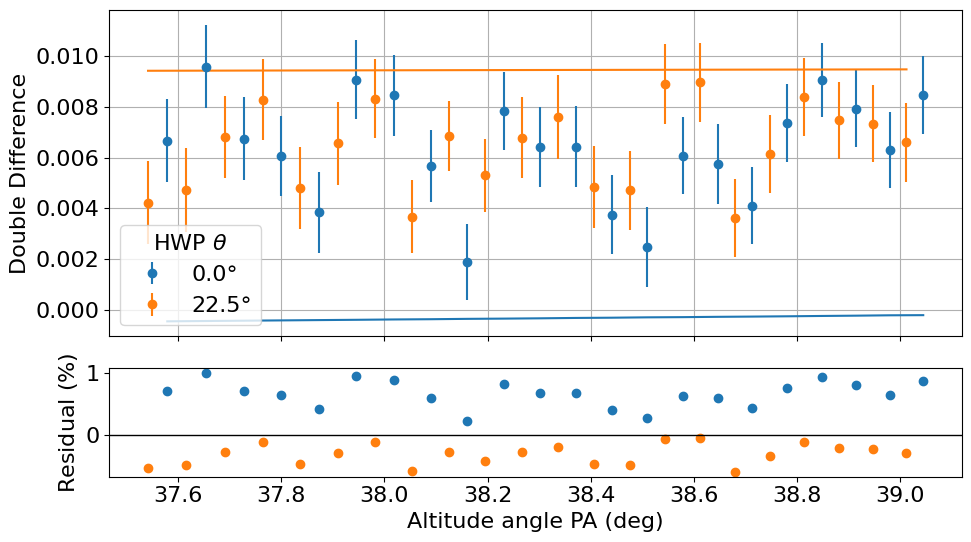

[-0.00021972  0.0094848  -0.00022527  0.00948259 -0.00023988  0.00948003
 -0.00025148  0.00947824 -0.00026472  0.00947608 -0.00027604  0.00947372
 -0.00028537  0.00947134 -0.00029806  0.00946861 -0.00030567  0.00946629
 -0.00032023  0.00946386 -0.00032938  0.00946123 -0.00034445  0.00945879
 -0.0003563   0.00945611 -0.00036559  0.00945333 -0.00037998  0.00945029
 -0.00038965  0.00944763 -0.00040289  0.00944481 -0.00041429  0.00944182
 -0.00042653  0.00943902 -0.0004381   0.0094359  -0.00045065  0.00943289
 -0.00046394  0.00942976]


np.float64(0.5955813579581306)

In [5]:
from pyMuellerMat.physical_models.charis_physical_models import *
from pyPolCal.constants import wavelength_bins
wavelength_bin = 10
offset_imr = -0.4506# derotator offset
offset_hwp = -1.119# HWP offset
offset_cal = -0.5905 # calibration polarizer offset
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
imr_phi = IMR_retardance(wavelength_bins,259.12694)[wavelength_bin]
hwp_phi = HWP_retardance(wavelength_bins,1.636,1.278)[wavelength_bin]
epsilon_cal = 1
m1, b1, m2, b2 = (1.94073,13.69728,2.07958,13.88817) # from MCMC
m3_diat = M3_diattenuation(wavelength_bins[wavelength_bin],m1,b1,m2,b2)
m3_ret = M3_retardance(wavelength_bins[wavelength_bin],m1,b1,m2,b2)

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here
system_dict = {
    "components" : {
        "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "beam": 'o'}, 
        "tag": "internal",
        },
        "image_rotator" : {
            "type" : "elliptical_IMR_function",
            "properties" : {"wavelength": wavelength_bins[wavelength_bin], "theta": imr_theta, "delta_theta": offset_imr},
            "tag": "internal",
        },
        "hwp" : {
            "type" : "general_retarder_function",
            "properties" : {"phi": hwp_phi, "theta": hwp_theta, "delta_theta": offset_hwp},
            "tag": "internal",
        },
        "diat" : {
            "type" : "diattenuator_retarder_function",
            "properties" : {"epsilon": 0, "delta_theta": 0},
            "tag": "internal",
        },
        "altitude_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
        "M3" : {
            "type" : "diattenuator_retarder_function",
            "properties" : {"epsilon": m3_diat, "theta": 0, "delta_theta":0},
            "tag": "internal",
        },

        "parang_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
}
}
system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

# Get our model retardances from Joost t Hart physical models

p = [m3_diat]


# Define what is in the p list

system_parameters = [['M3','epsilon']]

# Generate our modeled left and right beam intensities

modeled_interleaved = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(modeled_interleaved)

# Plot the modeled and observed values

fig, ax = plot_data_and_model_alt(interleaved_values, diffs_sums,configuration_list, interleaved_stds=interleaved_stds,wavelength= wavelength_bins[15],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)
diffs = process_dataset(interleaved_values)[::2]
print(diffs_sums[::2])
pol_acc = np.sqrt(np.sum((diffs*100-diffs_sums[::2]*100)**2)/(len(diffs)-6))
pol_acc

In [ ]:
# for csv in Path('../datacsvs/onsky_nbs/HD7808').glob('*.csv'):
#     df = pd.read_csv(csv)
#     df = df.iloc[:140] # first 140 rows
#     df.to_csv(csv, index=False)

/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6566e+03                                    3.67e+05    
       1              2         7.8707e+02      3.87e+03       1.63e-02       1.00e+05    
       2              3         4.6470e+02      3.22e+02       6.21e-03       6.11e+02    
       3              4         4.6469e+02      1.16e-02       3.76e-05       2.32e-02    
       4              5         4.6469e+02      1.60e-11       1.43e-09       8.21e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.6566e+03, final cost 4.6469e+02, first-order optimality 8.21e-05.
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.589e+00 -4.551e-06 ...  1.100e+00 -1.562e-05]
           x: [ 8.185e-03 -1.204e-02]
        cost: 464.68875617388585
         jac: [[ 2.527e+01 -5.531e+02]
               [-1.404e-05 -9.902e-06]
 

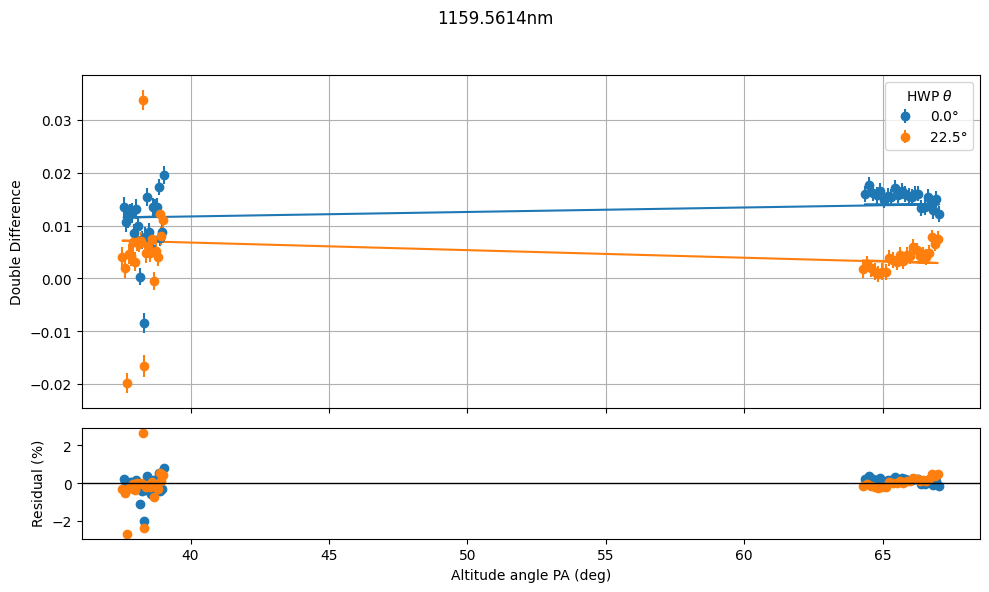

Updated Mueller Matrix:
[[ 0.49820836  0.00634846 -0.49720448 -0.03096718]
 [-0.49820836 -0.00634846  0.49720448  0.03096718]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -2.6883165180010185 2.6701756447385394
Error: [0.00056123 0.00056301]
s_res: 0.6011620426811227
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4902e+03                                    3.86e+05    
       1              2         4.7105e+02      4.02e+03       1.60e-02       1.11e+05    
       2              3         9.8006e+01      3.73e+02       6.54e-03       7.15e+02    
       3              4         9.7991e+01      1.53e-02       4.21e-05       3.05e-02    
       4              5         9.7991e+01      2.77e-11       1.80e-09       7.60e-06    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.4902e+03, final cost 9

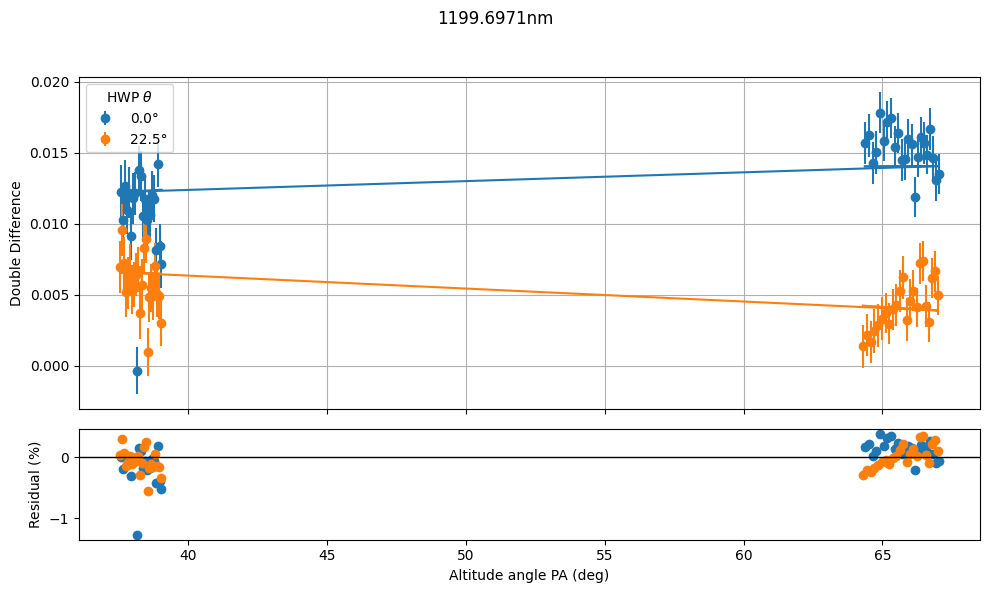

Updated Mueller Matrix:
[[ 0.49780135 -0.01461266 -0.4932418  -0.01383051]
 [-0.49365115  0.01485394  0.49738338  0.01394575]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.2646624388062606 0.3748667622336346
Error: [0.00025242 0.0002531 ]
s_res: 0.23845789607055734
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3815e+03                                    3.83e+05    
       1              2         4.6283e+02      3.92e+03       1.57e-02       1.10e+05    
       2              3         9.8015e+01      3.65e+02       6.45e-03       6.98e+02    
       3              4         9.8001e+01      1.44e-02       4.08e-05       2.88e-02    
       4              5         9.8001e+01      2.46e-11       1.68e-09       1.81e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.3815e+03, final cost 

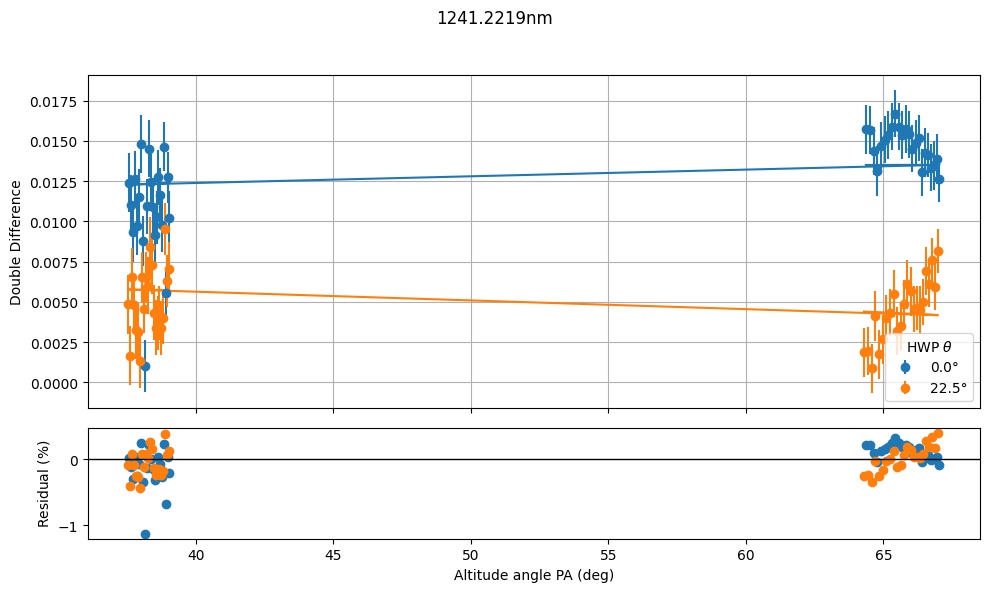

Updated Mueller Matrix:
[[ 0.49773884 -0.02862812 -0.49378715  0.00409316]
 [-0.4946327   0.02889256  0.49688192 -0.00411863]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.129177090299669 0.40023044962172993
Error: [0.0002516  0.00025214]
s_res: 0.23946042267696677
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2738e+03                                    3.77e+05    
       1              2         4.7429e+02      3.80e+03       1.55e-02       1.11e+05    
       2              3         1.0449e+02      3.70e+02       6.52e-03       7.11e+02    
       3              4         1.0447e+02      1.51e-02       4.20e-05       3.02e-02    
       4              5         1.0447e+02      2.66e-11       1.78e-09       7.48e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.2738e+03, final cost 

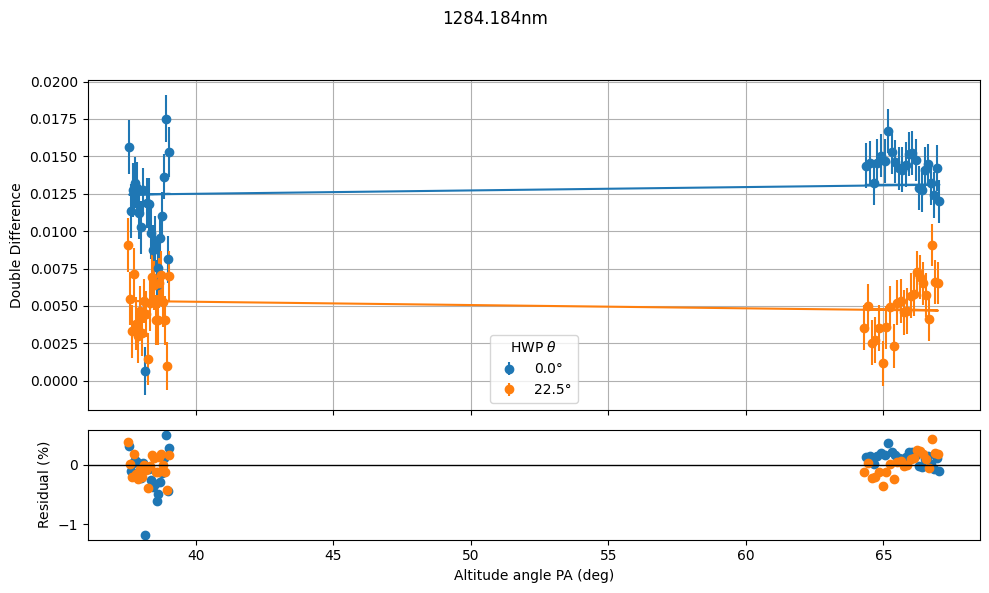

Updated Mueller Matrix:
[[ 0.49756796 -0.04030013 -0.48452652  0.0278837 ]
 [-0.48699659  0.04146024  0.49501694 -0.02848293]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.1802753542151974 0.5031204146059769
Error: [0.00026162 0.00026166]
s_res: 0.24723713460264177
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3357e+03                                    3.79e+05    
       1              2         5.4131e+02      3.79e+03       1.52e-02       1.16e+05    
       2              3         1.3489e+02      4.06e+02       6.83e-03       7.82e+02    
       3              4         1.3487e+02      1.82e-02       4.60e-05       3.64e-02    
       4              5         1.3487e+02      4.01e-11       2.14e-09       3.95e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.3357e+03, final cost 

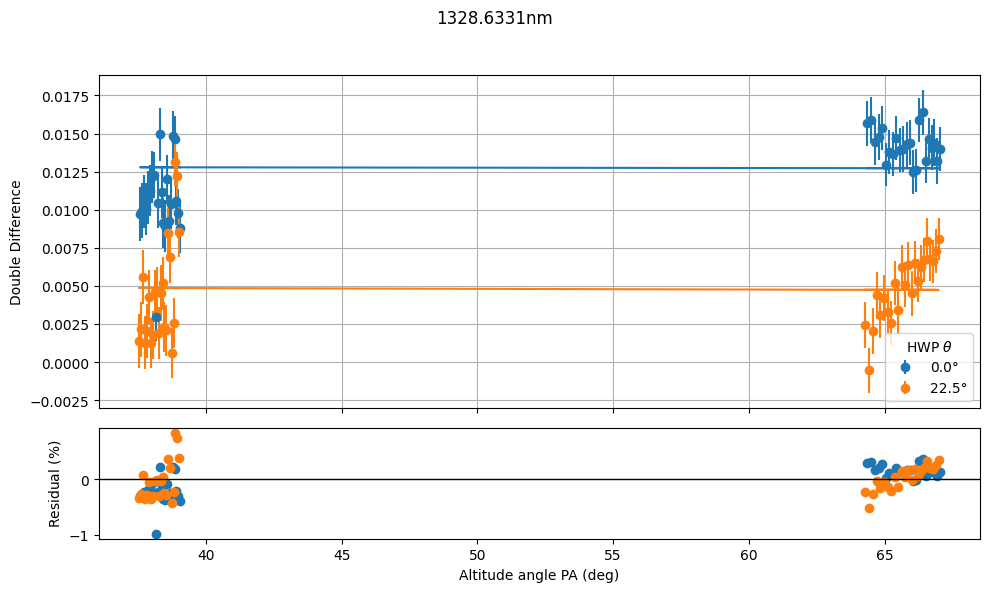

Updated Mueller Matrix:
[[ 0.49768372 -0.04487413 -0.46951682  0.08553249]
 [-0.47934572  0.04708795  0.48742999 -0.08877274]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.9804010030559813 0.8306473189162075
Error: [0.00029787 0.00029682]
s_res: 0.27925709174009256
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0038e+04                                    3.18e+05    
       1              2         6.9713e+03      3.07e+03       1.50e-02       9.04e+04    
       2              3         6.6928e+03      2.78e+02       6.05e-03       5.41e+02    
       3              4         6.6928e+03      9.92e-03       3.63e-05       2.01e-02    
       4              5         6.6928e+03      1.91e-11       1.35e-09       1.81e-04    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.0038e+04, final cost 

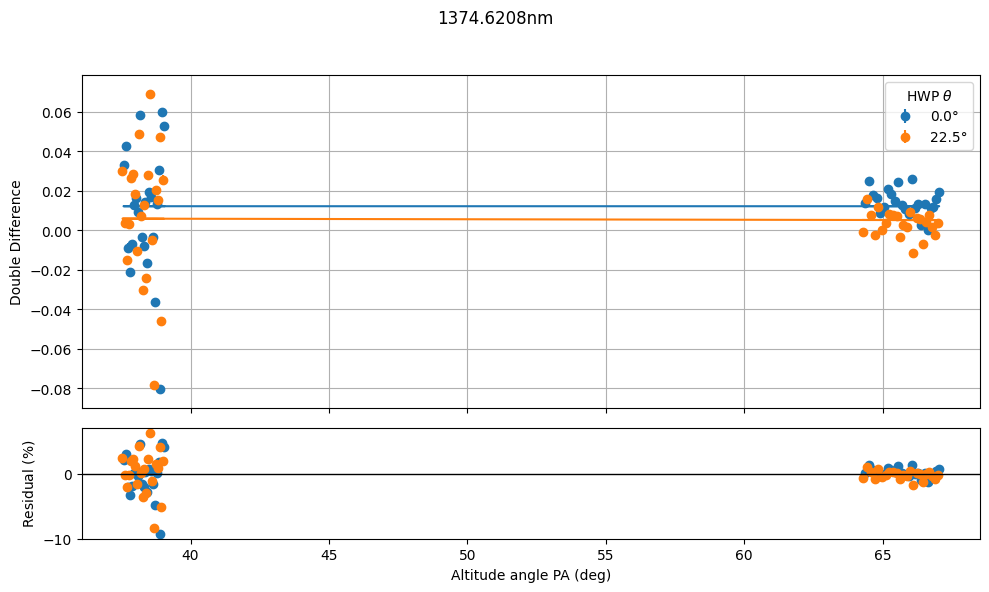

Updated Mueller Matrix:
[[ 0.49747865 -0.03648457 -0.47636344  0.11535182]
 [-0.49148585  0.03708171  0.48216164 -0.11674396]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -9.25055137307664 6.3218000668893435
Error: [0.00224276 0.0022335 ]
s_res: 2.3417455260106443
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3341e+03                                    3.69e+05    
       1              2         7.7239e+02      3.56e+03       1.48e-02       1.09e+05    
       2              3         4.2258e+02      3.50e+02       6.26e-03       6.69e+02    
       3              4         4.2257e+02      1.30e-02       3.83e-05       2.59e-02    
       4              5         4.2257e+02      1.88e-11       1.48e-09       7.76e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.3341e+03, final cost 4.2

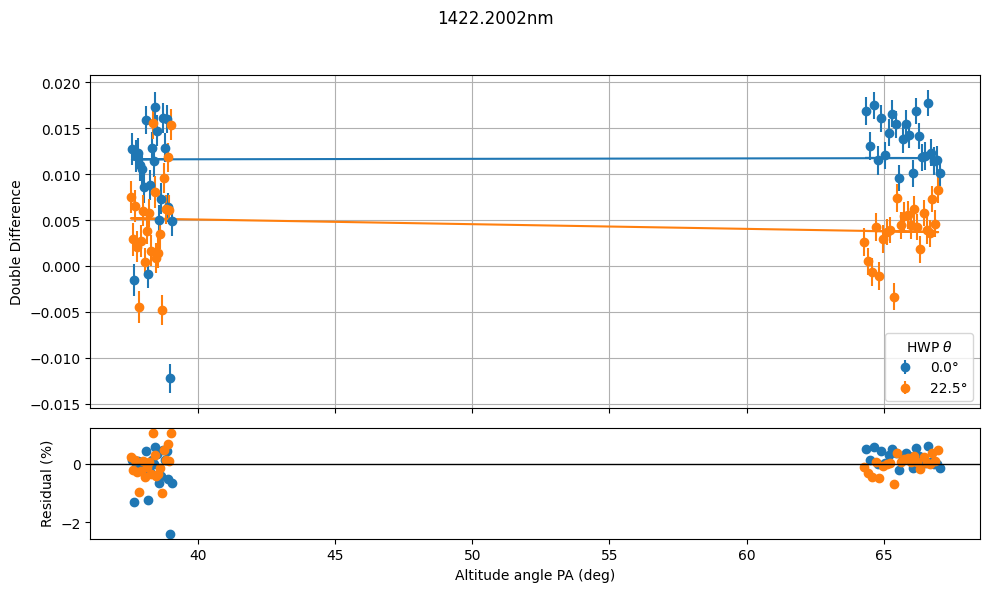

Updated Mueller Matrix:
[[ 0.49822814 -0.02333917 -0.47278738  0.1346835 ]
 [-0.49214973  0.02377748  0.4786207  -0.13633498]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -2.3911180772298497 1.0468947244707425
Error: [0.00052217 0.00051825]
s_res: 0.4967435204280458
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2694e+03                                    3.85e+05    
       1              2         5.7014e+02      3.70e+03       1.45e-02       1.20e+05    
       2              3         1.6183e+02      4.08e+02       6.66e-03       7.80e+02    
       3              4         1.6181e+02      1.71e-02       4.32e-05       3.41e-02    
       4              5         1.6181e+02      3.24e-11       1.88e-09       2.68e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.2694e+03, final cost 1

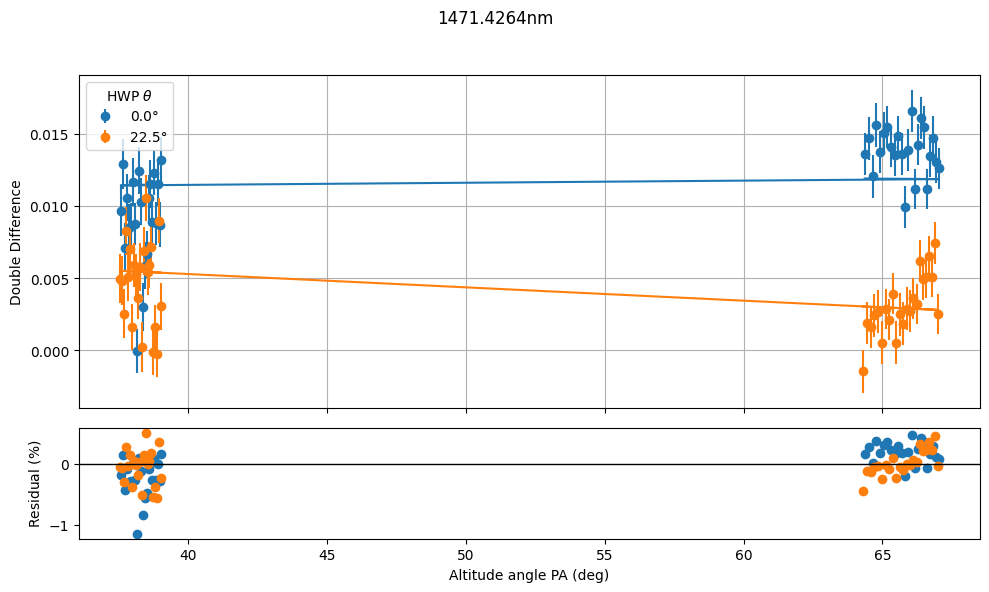

Updated Mueller Matrix:
[[ 0.49865273 -0.00371971 -0.46932119  0.1509786 ]
 [-0.49302118  0.00390362  0.47468205 -0.15269373]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.150670987792414 0.5135084092874652
Error: [0.00031825 0.00031546]
s_res: 0.29900412268320087
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9051e+03                                    3.68e+05    
       1              2         4.7745e+02      3.43e+03       1.43e-02       1.08e+05    
       2              3         1.4308e+02      3.34e+02       6.05e-03       6.45e+02    
       3              4         1.4307e+02      1.17e-02       3.60e-05       2.34e-02    
       4              5         1.4307e+02      1.53e-11       1.31e-09       2.89e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 3.9051e+03, final cost 1

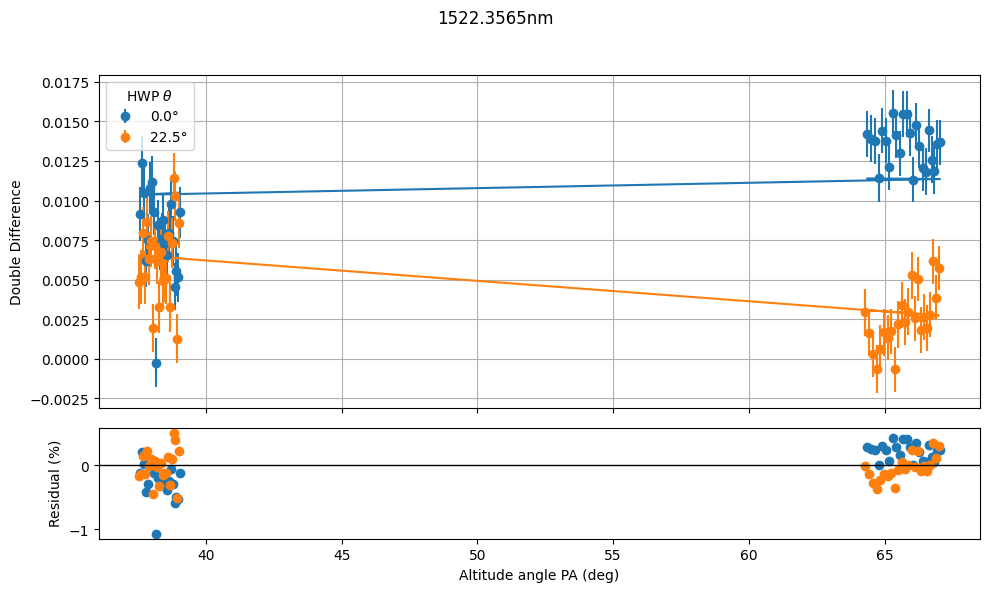

Updated Mueller Matrix:
[[ 0.49863746  0.01592891 -0.46638464  0.15968401]
 [-0.4932206  -0.01597278  0.47151286 -0.16142808]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.0673585875340306 0.5017459838296542
Error: [0.00030127 0.00029796]
s_res: 0.2762609135226169
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2898e+03                                    3.91e+05    
       1              2         6.1061e+02      3.68e+03       1.41e-02       1.28e+05    
       2              3         1.5525e+02      4.55e+02       6.97e-03       8.78e+02    
       3              4         1.5523e+02      2.13e-02       4.79e-05       4.25e-02    
       4              5         1.5523e+02      4.99e-11       2.32e-09       2.62e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.2898e+03, final cost 1

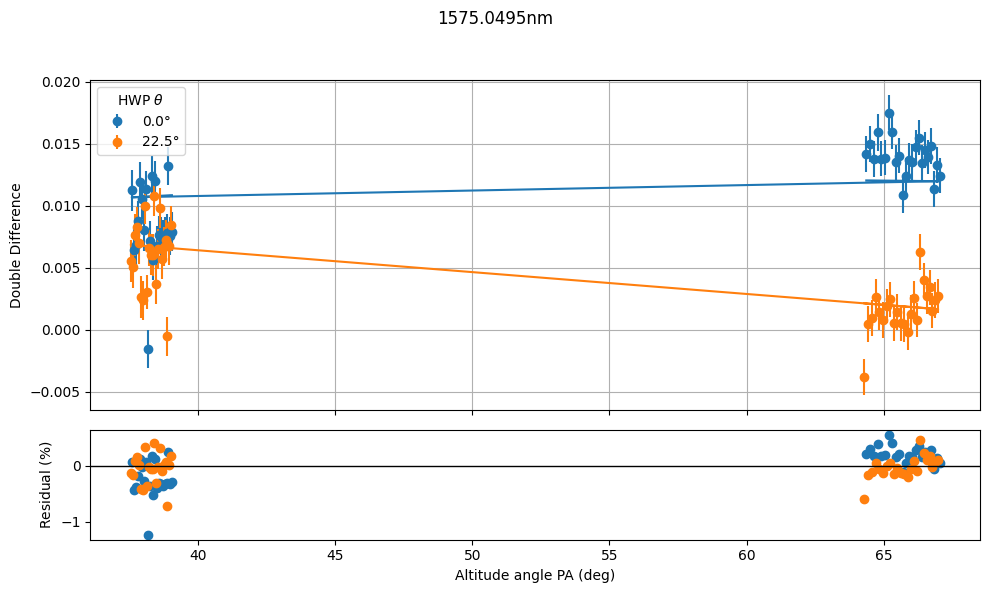

Updated Mueller Matrix:
[[ 0.4991244   0.03481982 -0.46508387  0.16230446]
 [-0.49381911 -0.0350587   0.47009088 -0.16404196]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.226154235760541 0.5471963138463425
Error: [0.00031017 0.00030658]
s_res: 0.2871036464239598
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9409e+03                                    3.79e+05    
       1              2         4.9339e+02      3.45e+03       1.39e-02       1.14e+05    
       2              3         1.3794e+02      3.55e+02       6.10e-03       6.87e+02    
       3              4         1.3793e+02      1.27e-02       3.66e-05       2.53e-02    
       4              5         1.3793e+02      1.61e-11       1.35e-09       3.67e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 3.9409e+03, final cost 1.

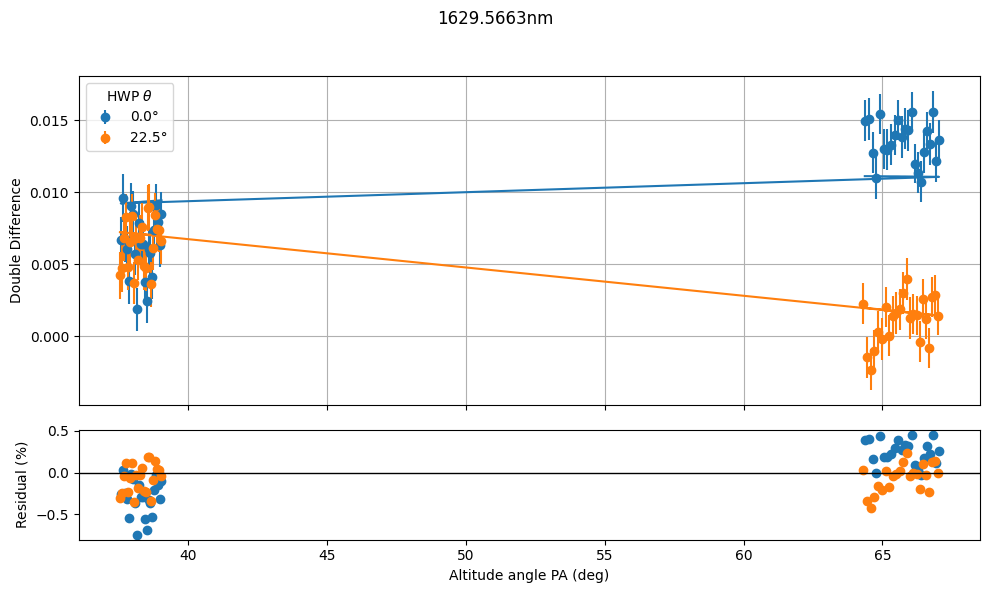

Updated Mueller Matrix:
[[ 0.49918275  0.05191191 -0.46363784  0.15981652]
 [-0.49314844 -0.05240521  0.46932736 -0.16176559]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.74338971426447 0.4496939604246193
Error: [0.00028933 0.00028597]
s_res: 0.2657545654182319
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1433e+03                                    3.96e+05    
       1              2         5.9158e+02      3.55e+03       1.37e-02       1.21e+05    
       2              3         2.1249e+02      3.79e+02       6.16e-03       7.37e+02    
       3              4         2.1248e+02      1.40e-02       3.76e-05       2.79e-02    
       4              5         2.1248e+02      2.00e-11       1.42e-09       1.27e-04    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.1433e+03, final cost 2.1

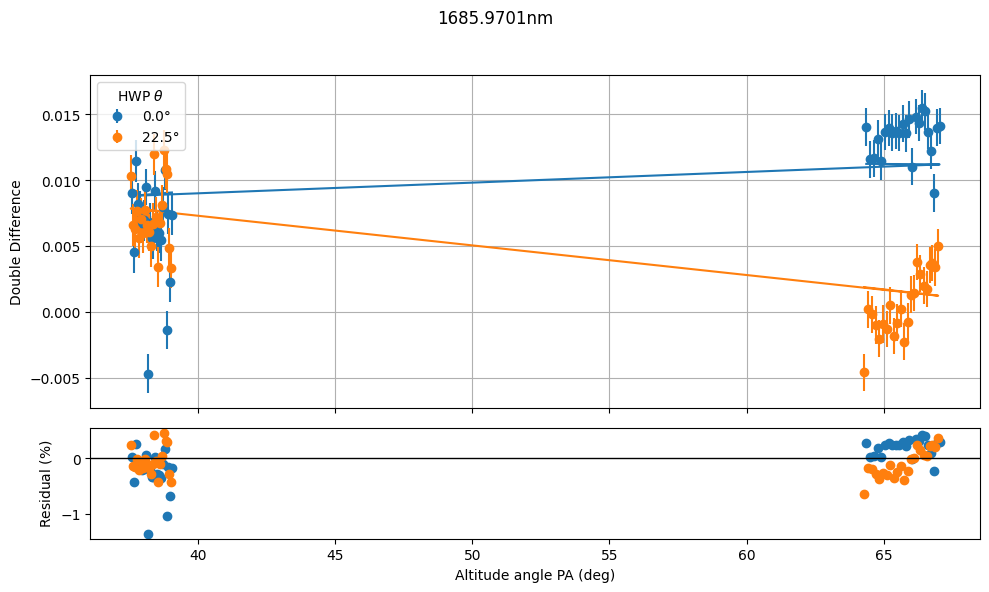

Updated Mueller Matrix:
[[ 0.49923063  0.06557442 -0.46354331  0.15396891]
 [-0.49282647 -0.06627517  0.46958848 -0.15596343]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.3587187584039995 0.4640824624530824
Error: [0.00035105 0.00034696]
s_res: 0.3205249573782281
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2465e+03                                    4.04e+05    
       1              2         6.0113e+02      3.65e+03       1.36e-02       1.32e+05    
       2              3         1.4917e+02      4.52e+02       6.71e-03       8.74e+02    
       3              4         1.4915e+02      1.96e-02       4.43e-05       3.92e-02    
       4              5         1.4915e+02      4.01e-11       1.99e-09       7.83e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.2465e+03, final cost 1

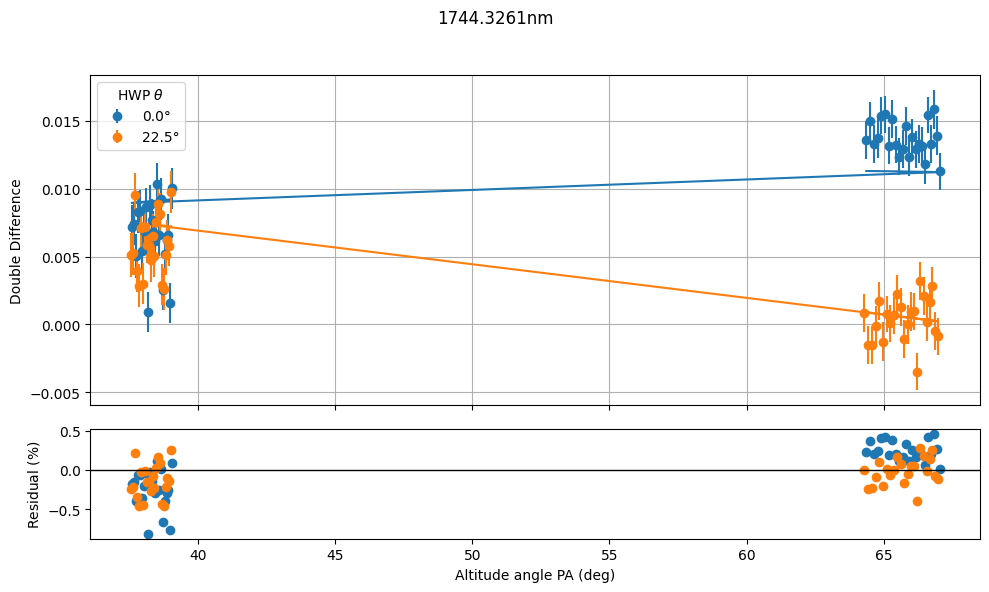

Updated Mueller Matrix:
[[ 0.49968434  0.07473207 -0.46571804  0.14691711]
 [-0.49402634 -0.07545465  0.47107219 -0.14859757]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.814230854909734 0.46070995540193294
Error: [0.00029318 0.00029006]
s_res: 0.27052932832345944
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6572e+03                                    4.16e+05    
       1              2         1.0132e+03      3.64e+03       1.34e-02       1.26e+05    
       2              3         6.3093e+02      3.82e+02       5.93e-03       7.39e+02    
       3              4         6.3092e+02      1.29e-02       3.47e-05       2.58e-02    
       4              5         6.3092e+02      1.71e-11       1.21e-09       1.76e-04    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.6572e+03, final cost 

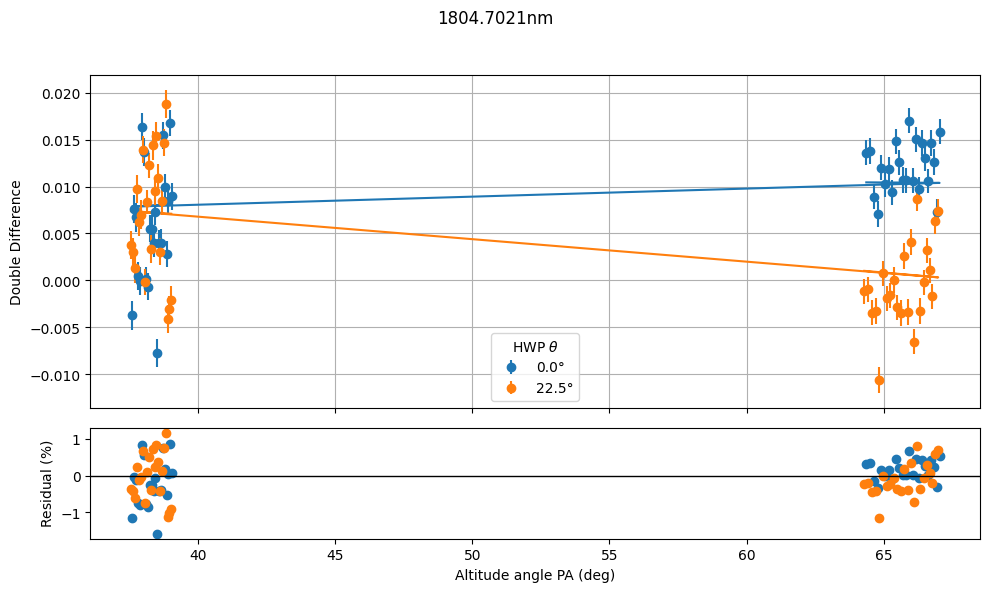

Updated Mueller Matrix:
[[ 0.49961048  0.08068519 -0.46654507  0.13820335]
 [-0.49322795 -0.08159064  0.47260549 -0.13998891]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.5816621338199497 1.1665155945315693
Error: [0.00057977 0.00057369]
s_res: 0.5411799669121709
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.9626e+03                                    5.04e+05    
       1              2         5.2000e+03      4.76e+03       1.33e-02       2.17e+05    
       2              3         4.0845e+03      1.12e+03       1.02e-02       2.19e+03    
       3              4         4.0843e+03      1.16e-01       1.04e-04       2.31e-01    
       4              5         4.0843e+03      1.30e-09       1.11e-08       1.55e-04    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 9.9626e+03, final cost 4

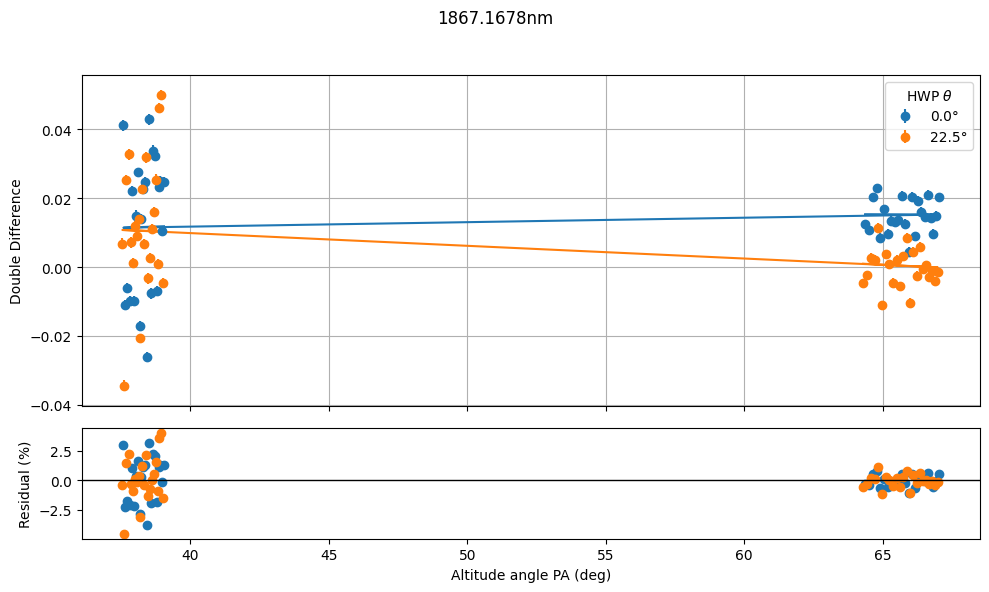

Updated Mueller Matrix:
[[ 0.49965747  0.0884581  -0.46798974  0.12823176]
 [-0.49323523 -0.08940607  0.4741189  -0.12989909]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -4.527586364294026 3.9607565656661823
Error: [0.00147867 0.00147066]
s_res: 1.436443803622261
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1926e+03                                    4.09e+05    
       1              2         7.2940e+02      3.46e+03       1.31e-02       1.20e+05    
       2              3         3.9309e+02      3.36e+02       5.51e-03       6.53e+02    
       3              4         3.9308e+02      9.87e-03       3.00e-05       1.96e-02    
       4              5         3.9308e+02      7.96e-12       9.00e-10       1.30e-04    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.1926e+03, final cost 3.9

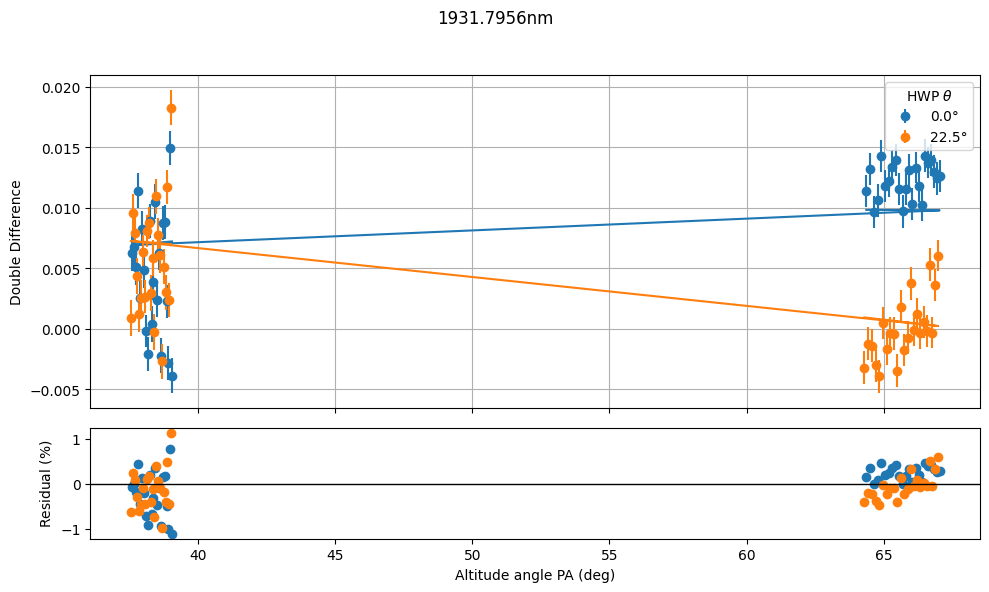

Updated Mueller Matrix:
[[ 0.49960179  0.08811153 -0.47029054  0.11800668]
 [-0.49281001 -0.0891883   0.47679688 -0.11963037]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.1090649182815429 1.1286663982568599
Error: [0.00045169 0.00044828]
s_res: 0.4230414302547228
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6199e+03                                    4.57e+05    
       1              2         7.0044e+02      3.92e+03       1.29e-02       1.51e+05    
       2              3         2.0616e+02      4.94e+02       6.46e-03       9.68e+02    
       3              4         2.0614e+02      2.04e-02       4.17e-05       4.08e-02    
       4              5         2.0614e+02      3.56e-11       1.76e-09       7.39e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.6199e+03, final cost 2

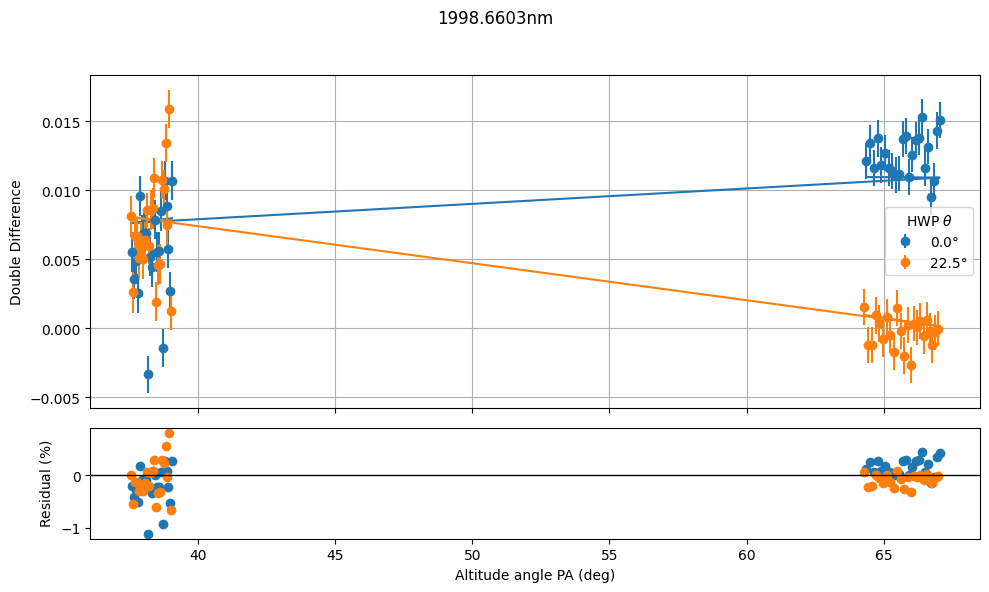

Updated Mueller Matrix:
[[ 0.49957759  0.08946724 -0.47384302  0.10778025]
 [-0.49411283 -0.09033448  0.47910567 -0.10897022]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.1086348005002444 0.8086765903606138
Error: [0.00031618 0.00031451]
s_res: 0.2993554341424262
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5901e+03                                    4.64e+05    
       1              2         6.5173e+02      3.94e+03       1.28e-02       1.54e+05    
       2              3         1.5398e+02      4.98e+02       6.40e-03       9.74e+02    
       3              4         1.5396e+02      2.01e-02       4.09e-05       4.01e-02    
       4              5         1.5396e+02      3.35e-11       1.68e-09       2.57e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.5901e+03, final cost 1

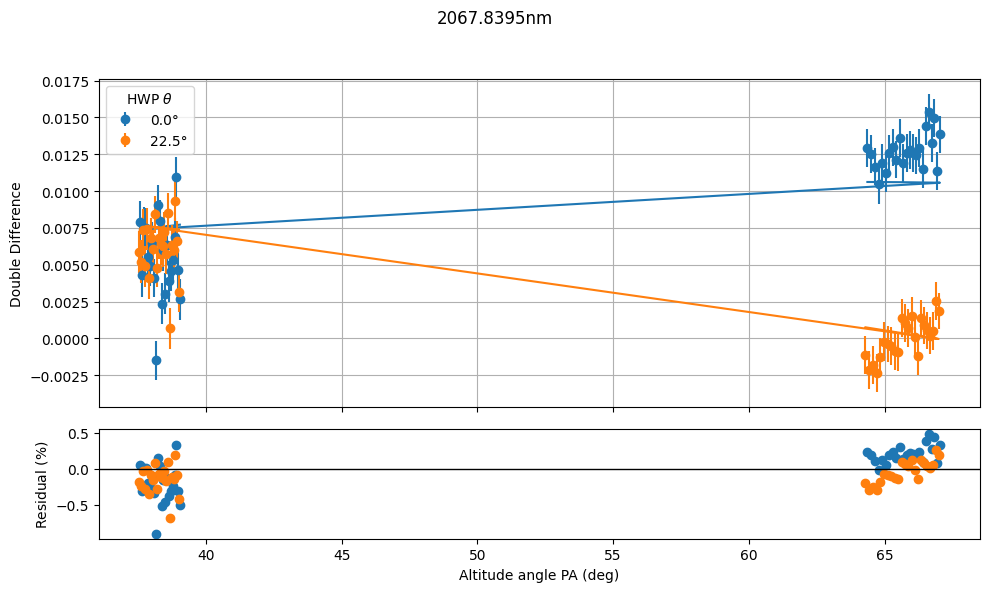

Updated Mueller Matrix:
[[ 0.49965945  0.08914382 -0.47500826  0.09553709]
 [-0.49265198 -0.09025969  0.48179192 -0.09689411]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.9002129669578942 0.4795799925154991
Error: [0.00026946 0.00026828]
s_res: 0.25143897674341986
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4801e+03                                    4.64e+05    
       1              2         6.1503e+02      3.87e+03       1.26e-02       1.47e+05    
       2              3         1.7397e+02      4.41e+02       5.92e-03       8.58e+02    
       3              4         1.7396e+02      1.50e-02       3.47e-05       3.00e-02    
       4              5         1.7396e+02      1.76e-11       1.22e-09       3.55e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.4801e+03, final cost 

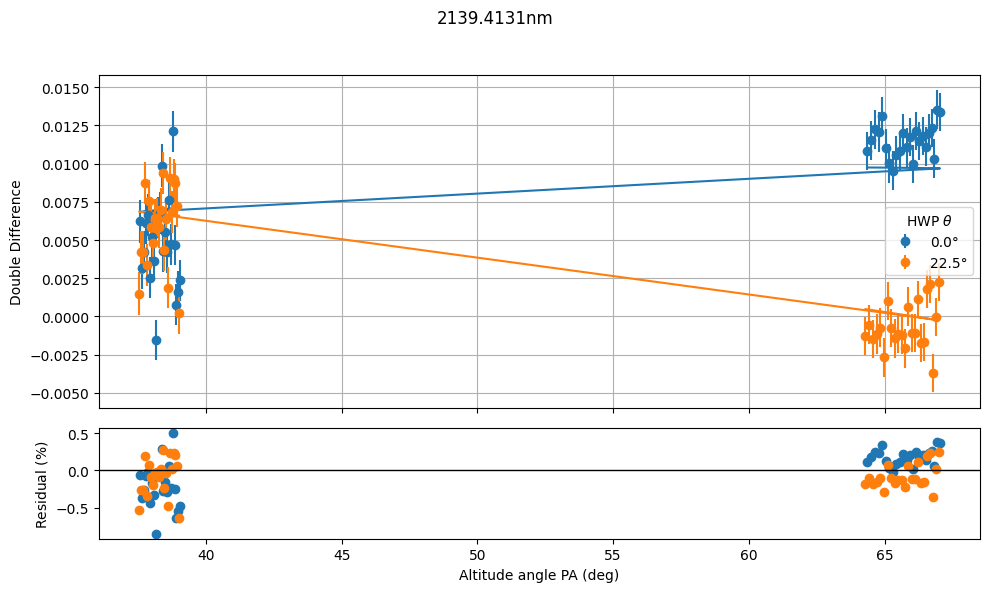

Updated Mueller Matrix:
[[ 0.4997712   0.0877723  -0.47828522  0.08269069]
 [-0.4932523  -0.08880293  0.48462886 -0.08378252]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.847899657584896 0.5028469287192029
Error: [0.00028035 0.00028004]
s_res: 0.26412491344904443
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9712e+03                                    4.98e+05    
       1              2         8.0351e+02      4.17e+03       1.25e-02       1.70e+05    
       2              3         2.3644e+02      5.67e+02       6.58e-03       1.11e+03    
       3              4         2.3641e+02      2.43e-02       4.34e-05       4.87e-02    
       4              5         2.3641e+02      4.70e-11       1.90e-09       4.05e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 4.9712e+03, final cost 2

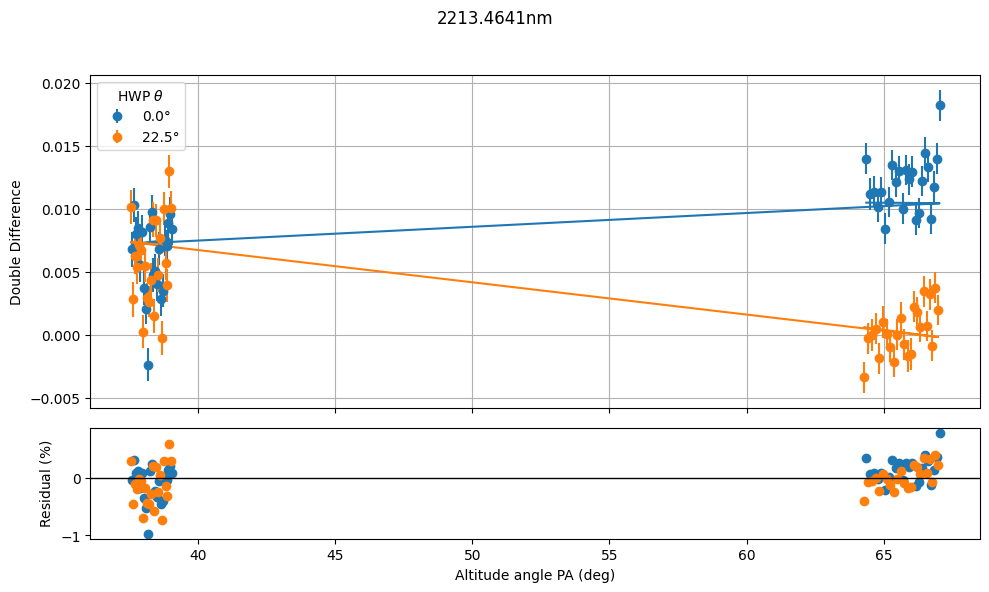

Updated Mueller Matrix:
[[ 0.49968472  0.0859281  -0.47809797  0.06797558]
 [-0.4904905  -0.08734132  0.48709337 -0.06924813]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -0.970153499944793 0.7763925210002922
Error: [0.0003205 0.0003205]
s_res: 0.2982044465695228
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2992e+03                                    4.93e+05    
       1              2         1.1656e+03      4.13e+03       1.24e-02       1.73e+05    
       2              3         5.7030e+02      5.95e+02       6.77e-03       1.15e+03    
       3              4         5.7027e+02      2.64e-02       4.54e-05       5.29e-02    
       4              5         5.7027e+02      5.55e-11       2.08e-09       5.52e-05    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 5.2992e+03, final cost 5.70

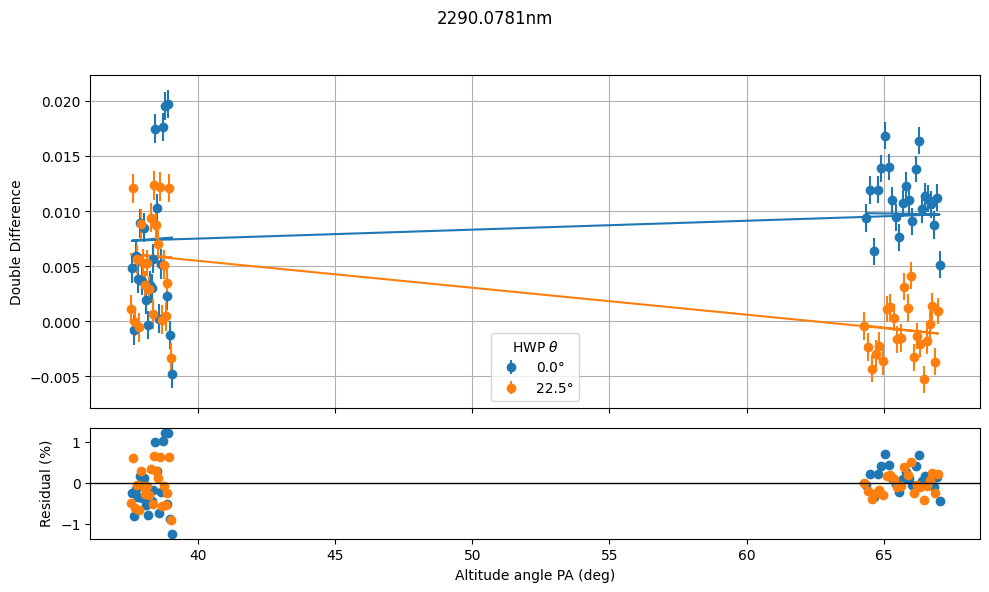

Updated Mueller Matrix:
[[ 0.50015874  0.08277013 -0.47763718  0.0516658 ]
 [-0.48749999 -0.08466235  0.49008151 -0.05300828]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -1.2363254888518023 1.2124377576616174
Error: [0.00049811 0.00049987]
s_res: 0.4650806801580273
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.9253e+03                                    4.81e+05    
       1              2         2.9520e+03      3.97e+03       1.23e-02       1.56e+05    
       2              3         2.4730e+03      4.79e+02       5.95e-03       9.08e+02    
       3              4         2.4730e+03      1.57e-02       3.43e-05       3.13e-02    
       4              5         2.4730e+03      1.91e-11       1.18e-09       1.34e-04    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 6.9253e+03, final cost 2

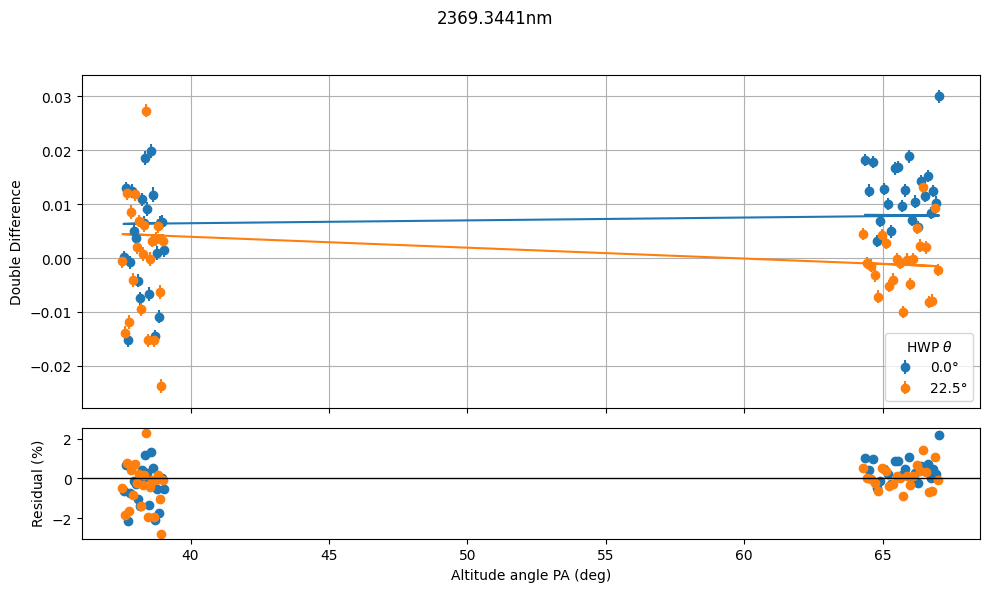

Updated Mueller Matrix:
[[ 0.50042584  0.07790149 -0.46934226  0.03290065]
 [-0.47689789 -0.08134057  0.49256063 -0.03452679]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
360 180
Residuals range: -2.7918510291446874 2.303254635615161
Error: [0.00101172 0.00102046]
s_res: 0.9272253646680713


In [1]:
from pyPolCal.on_sky import fit_CHARIS_Mueller_matrix_by_bin_m3
errs = []
sres = []
for bin in range(22):
    fname = f'../datacsvs/onsky_nbs/HD10166_and_HD293396/bin{bin}.csv'
    sys_dict = f'../system_dictionaries/nbs_in_onsky/bin{bin}.json'
    err,fig, ax, sr = fit_CHARIS_Mueller_matrix_by_bin_m3(fname,bin,sys_dict)
    errs.append(err)
    sres.append(sr)

In [2]:
from pyPolCal.csv_tools import model_data
from pathlib import Path
jsondir = Path('/home/thomasmc/pyPolCal/pyPolCal/CHARIS/system_dictionaries/nbs_in_onsky')
df = model_data(jsondir)
df

,wavelength_bin,M3_d_45,M3_d_h
0,1159.5614,-0.012041,0.008185
1,1199.6971,-0.012232,0.008505
2,1241.2219,-0.011852,0.008109
3,1284.1840,-0.011742,0.008169
4,1328.6331,-0.011819,0.007920
5,1374.6208,-0.010882,0.008321
6,1422.2002,-0.010717,0.007050
7,1471.4264,-0.010895,0.006731
8,1522.3565,-0.010171,0.007074
9,1575.0495,-0.010908,0.006789


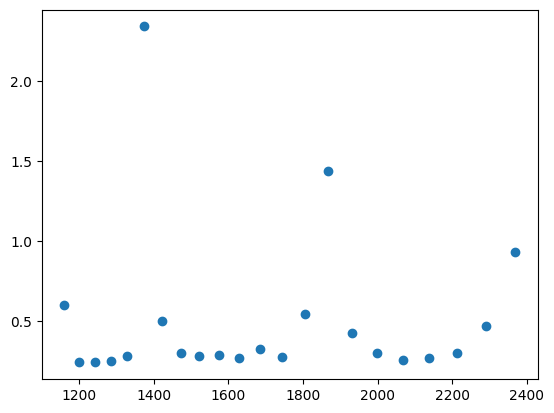

In [3]:
import matplotlib.pyplot as plt
from pyPolCal.constants import wavelength_bins
plt.scatter(wavelength_bins, sres)

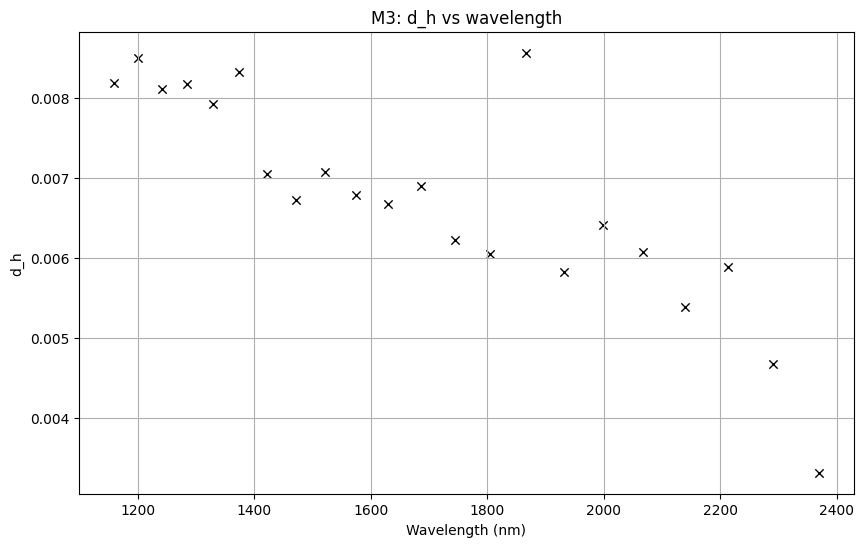

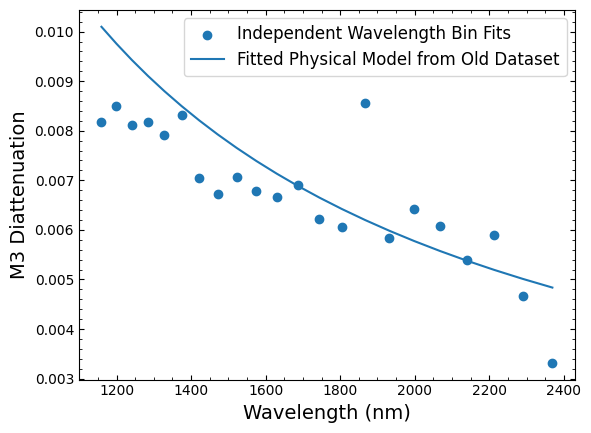

In [6]:
from pyPolCal.plotting import plot_config_dict_vs_wavelength
from pyMuellerMat.physical_models.charis_physical_models import *
params, fig, ax = plot_config_dict_vs_wavelength('M3','d_h',jsondir)
fig2, ax2 = plt.subplots()
ax2.scatter(wavelength_bins,params, label='Independent Wavelength Bin Fits')
ax2.plot(wavelength_bins, M3_diattenuation(wavelength_bins), label='Fitted Physical Model from Old Dataset')
ax2.legend(fontsize=12)
ax2.set_xlabel('Wavelength (nm)', fontsize=14)
ax2.set_ylabel('M3 Diattenuation', fontsize=14)
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()


In [9]:
# global minimize
interleaved_values_glob, interleaved_stds_glob, configuration_list_glob = read_csv_physical_model_all_bins('../datacsvs/onsky_nbs/HD10166_and_HD293396/',m3=True)

wavelength_bin = 10
# Loading in past fits 
offset_imr = -0.4506# derotator offset
offset_hwp = -1.119# HWP offset
offset_cal = -0.5905 # calibration polarizer offset
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
imr_phi = IMR_retardance(wavelength_bins,259.12694)[wavelength_bin]
hwp_phi = HWP_retardance(wavelength_bins,1.636,1.278)[wavelength_bin]
epsilon_cal = 1
m1, b1, m2, b2 = (1.94073,13.69728,2.07958,13.88817) # from MCMC
m3_diat = M3_diattenuation(wavelength_bins[wavelength_bin],m1,b1,m2,b2)
m3_ret = M3_retardance(wavelength_bins[wavelength_bin],m1,b1,m2,b2)

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here
system_dict = {
    "components" : {
        "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "beam": 'o'}, 
        "tag": "internal",
        },
        "image_rotator" : {
            "type" : "elliptical_IMR_function",
            "properties" : {"wavelength": wavelength_bins[wavelength_bin], "theta": imr_theta, "delta_theta": offset_imr},
            "tag": "internal",
        },
        "hwp" : {
            "type" : "two_layer_HWP_function",
            "properties" : {"wavelength":wavelength_bins[wavelength_bin], "w_SiO2":1.636, "w_MgF2":1.278,"theta": hwp_theta, "delta_theta": offset_hwp},
            "tag": "internal",
        },
        "altitude_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
        "M3" : {
            "type" : "SUBARU_M3_function",
            "properties" : {"m1":m1, "m2":m2, "b1":b1, "b2":b2},
            "tag": "internal",
        },

        "parang_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
}}

# Converting system dictionary into system Mueller Matrix object
system_mm = generate_system_mueller_matrix(system_dict)

# Define initial guesses for our parameters 

# MODIFY THIS IF YOU WANT TO CHANGE PARAMETERS
p0_dict = {
    "M3": {
        "m1": m1,
        "m2": m2,
        "b1": b1,
        "b2": b2
    }
}

m1_bounds = (0.7*m1, 1.3*m1)
m2_bounds = (0.7*m2, 1.3*m2)
b1_bounds = (0.7*b1, 1.3*b1)
b2_bounds = (0.7*b2, 1.3*b2)
bounds = [m1_bounds, m2_bounds, b1_bounds, b2_bounds]


In [11]:
from pyPolCal.fitting import minimize_system_mueller_matrix
result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_glob,
                               configuration_list_glob,interleaved_stds_glob,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=bounds,mode='minimize')
print(result_min)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 42613.62642104185
        x: [ 2.523e+00  2.316e+00  1.514e+01  1.235e+01]
      nit: 42
      jac: [-2.302e+01 -5.086e-01  1.237e+00  1.578e+00]
     nfev: 300
     njev: 60
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


In [13]:
def calc_s_res_global(csvdir, system_dict,p0_dict, number_of_fitted_params, m3=False):
    """
    Calculate s_res as in VLT SPHERE 2019 polcal appendix E for all CHARIS
    wavelength bins. All system dict mueller matrices must be a function of wavelength
    except for what is in the configuration list.

    Parameters
    -----------
    csvdir : str
        Path to the directory containing the CSV files.
    system_dict : dict
        Dictionary containing system parameters.
    p0_dict : dict
        Dictionary containing initial guess parameters.
    number_of_fitted_params : int
        Number of parameters fitted using the data in <csvdir>.
    m3 : bool, optional
        Whether or not m3 is in the system dictionary. Default is False.

    Returns
    --------
    list
        A list of s_res values for each wavelength bin.

    """

    # generate system mueller matrix
    system_mm_ = generate_system_mueller_matrix(system_dict)

    # read csv into single differences and parse configuration list
    interleaved_values, interleaved_stds, configuration_list = read_csv_physical_model_all_bins(csvdir, m3=m3)
    p0_values, p0_keywords = parse_configuration(p0_dict)

    # update system mm with p0 
    system_mm = update_system_mm(p0_values,p0_keywords,system_mm_)

    # generate simulated normalized single differences
    LR_intensities = model(p0_values, p0_keywords, system_mm, configuration_list)

    # process into modeled double differences
    modeled_diffs = process_model(LR_intensities)[::2]

    # process observed data into double differences
    obs_diff = process_dataset(interleaved_values)[::2]

    # convert units to percent and calculate residuals
    residuals = obs_diff*100 - modeled_diffs*100

    # group by wavelength bin using a bin mask
    s_res_by_wavelength = []
    for bin in range(22):
        # mask per bin
        bin_mask = []
        for dict in configuration_list[::2]:
            if dict['hwp']['wavelength'] == wavelength_bins[bin]:
                bin_mask.append(True)
            else:
                bin_mask.append(False)
        # apply mask
        double_diffs_by_bin = obs_diff[bin_mask]
        modeled_diffs_by_bin = modeled_diffs[bin_mask]
        residuals_by_bin = double_diffs_by_bin*100-modeled_diffs_by_bin*100
        # calculate s_res
        s_res = np.sqrt(np.sum(residuals_by_bin**2)/(len(double_diffs_by_bin)-number_of_fitted_params))
        s_res_by_wavelength.append(s_res)

    return s_res_by_wavelength




In [14]:

system_dict = {
    "components" : {
        "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": 500, "beam": 'o'}, 
        "tag": "internal",
        },
        "image_rotator" : {
            "type" : "elliptical_IMR_function",
            "properties" : {"wavelength": 1000, "theta": 0, "delta_theta": offset_imr},
            "tag": "internal",
        },
        "hwp" : {
            "type" : "two_layer_HWP_function",
            "properties" : {"wavelength":1000, "w_SiO2":1.636, "w_MgF2":1.278,"theta": 0, "delta_theta": offset_hwp},
            "tag": "internal",
        },
        "altitude_rot" : {
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
        "M3" : {
            "type" : "SUBARU_naive_M3_function",
            "properties" : {"wavelength":1000},
            "tag": "internal",
        },

        "parang_rot" : {        
            "type" : "rotator_function",
            "properties" : {"pa":0},
            "tag":"internal",
        },
}}

p0_dict = {
    'hwp': {
        'delta_theta': offset_hwp}
    }
csvdir = Path('../datacsvs/onsky_nbs/HD10166_and_HD293396/')
s_res = calc_s_res_global(csvdir, system_dict, p0_dict, number_of_fitted_params=2, m3=True)

[np.float64(0.597736590053061), np.float64(0.23709915055972305), np.float64(0.238095964717317), np.float64(0.24582836453342388), np.float64(0.2776658702874877), np.float64(2.328402138043983), np.float64(0.4939130499779588), np.float64(0.29730038161984546), np.float64(0.2746867644495379), np.float64(0.2854677148941132), np.float64(0.2642402820638283), np.float64(0.31869858947796303), np.float64(0.2689878381213495), np.float64(0.5380962952757418), np.float64(1.4282588720184026), np.float64(0.4206309181528906), np.float64(0.2976496912880796), np.float64(0.25000626435884943), np.float64(0.26261991593643447), np.float64(0.29650526210231076), np.float64(0.46243062622081776), np.float64(0.9219419862497628)]


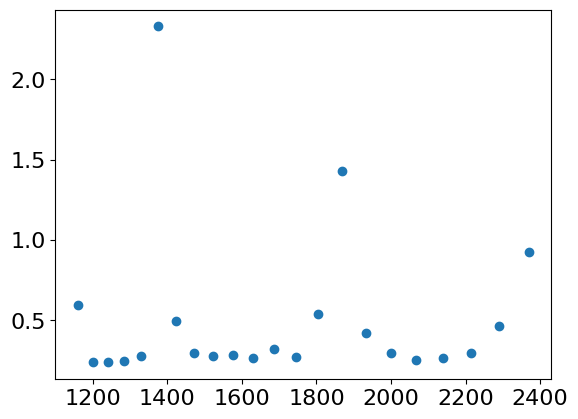

In [ ]:
plt.scatter(wavelength_bins,s_res)